<a href="https://colab.research.google.com/github/suryanshshah2006/Brain-Tumor-detection/blob/main/Brain_Tumor_Classification_Using_EfficientNetV2B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q kaggle

In [ ]:
import json
import os

kaggle_username = 'suryanshshah'
kaggle_token = 'KGAT_c6e62e674ce15cae2dd30a93bf313757'

! mkdir -p ~/.kaggle
with open('kaggle.json', 'w') as f:
    json.dump({"username": kaggle_username, "key": kaggle_token}, f)

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

print("Kaggle authentication successful!")

Kaggle authentication successful!


In [ ]:
! kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 87% 130M/149M [00:00<00:00, 1.35GB/s]
100% 149M/149M [00:00<00:00, 1.23GB/s]


In [ ]:
! unzip brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
import os, numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

print("TF:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices("GPU"))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except:
        pass

SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)

TF: 2.19.0
GPU available: []


In [ ]:
train_dir = "/content/Training"
test_dir  = "/content/Testing"

IMG_SIZE = (224, 224)
BATCH_SIZE = 16
VAL_SPLIT = 0.12

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names, "num_classes:", num_classes)

Found 5712 files belonging to 4 classes.
Using 5027 files for training.
Found 5712 files belonging to 4 classes.
Using 685 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary'] num_classes: 4


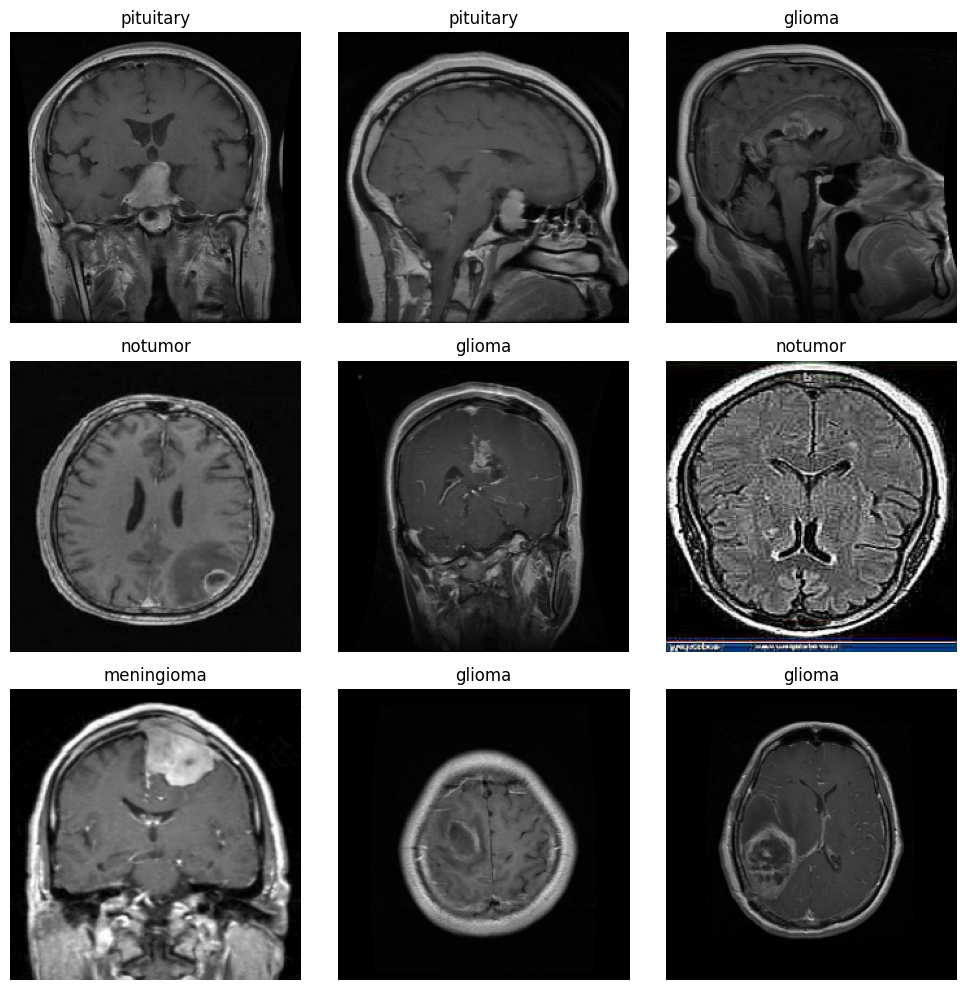

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_index = np.argmax(labels[i])
        plt.title(class_names[label_index])
        plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_perf = train_ds.cache().prefetch(AUTOTUNE)
val_ds_perf   = val_ds.cache().prefetch(AUTOTUNE)
test_ds_perf  = test_ds.cache().prefetch(AUTOTUNE)

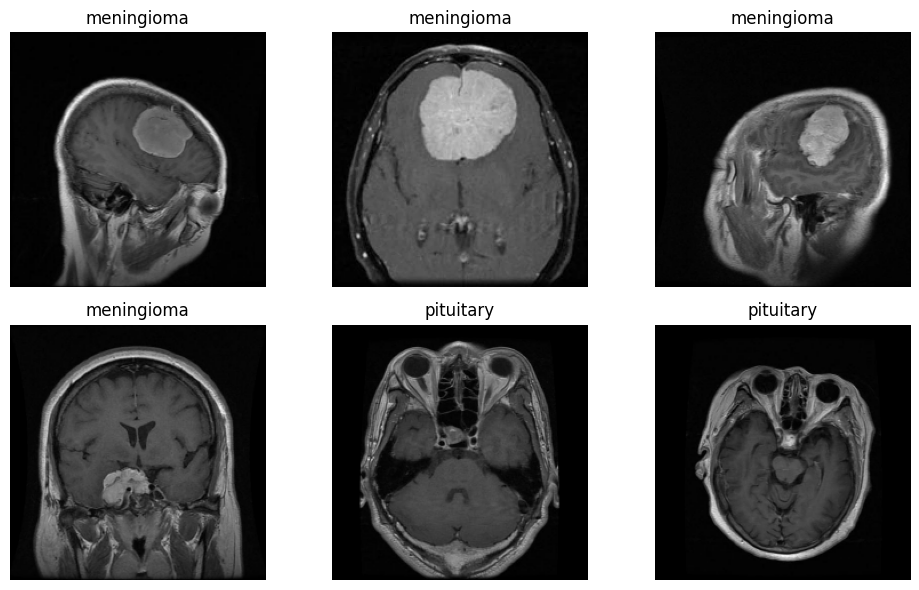

In [ ]:
x, y = next(iter(train_ds))
plt.figure(figsize=(10,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x[i].numpy().astype("uint8"))
    plt.title(class_names[int(tf.argmax(y[i]))])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.10),
    tf.keras.layers.RandomContrast(0.10),
], name="aug")

In [ ]:
tf.keras.backend.clear_session()

preprocess = tf.keras.applications.efficientnet_v2.preprocess_input

inputs = tf.keras.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.layers.Lambda(preprocess, name="preprocess")(x)

base = tf.keras.applications.EfficientNetV2B1(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)
base.trainable = False

x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.35)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()

28456008/28456008 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aug (Sequential)                │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocess (Lambda)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b1 (Functional)  │ (None, 7, 7, 1280)     │     6,931,124 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,936,248 (26.46 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 6,931,124 (26.44 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
ckpt_path = "best_effnetv2b1.keras"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy",
        save_best_only=True, mode="max", verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=6,
        restore_best_weights=True, mode="max", verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.3, patience=2,
        min_lr=1e-6, verbose=1
    )
]

In [ ]:
EPOCHS_PHASE1 = 6

history1 = model.fit(
    train_ds_perf,
    validation_data=val_ds_perf,
    epochs=EPOCHS_PHASE1,
    callbacks=callbacks
)

Epoch 1/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6466 - loss: 0.8422
Epoch 1: val_accuracy improved from -inf to 0.84818, saving model to best_effnetv2b1.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.6469 - loss: 0.8416 - val_accuracy: 0.8482 - val_loss: 0.3953 - learning_rate: 0.0010
Epoch 2/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8331 - loss: 0.4484
Epoch 2: val_accuracy improved from 0.84818 to 0.86277, saving model to best_effnetv2b1.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 432s 1s/step - accuracy: 0.8331 - loss: 0.4483 - val_accuracy: 0.8628 - val_loss: 0.3527 - learning_rate: 0.0010
Epoch 3/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8533 - loss: 0.3888
Epoch 3: val_accuracy improved from 0.86277 to 0.89197, saving model to best_effnetv2b1.keras
315/315 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.8533 - loss: 0.3887 - val_accuracy: 0.8920 - val_loss: 0.3190 - learning_rate: 0.0010
Epoch 4/6
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 1

In [16]:
base.trainable = True

fine_tune_at = int(len(base.layers) * 0.6)
for layer in base.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS_PHASE2 = 24
history2 = model.fit(
    train_ds_perf,
    validation_data=val_ds_perf,
    epochs=EPOCHS_PHASE2,
    callbacks=callbacks
)

Epoch 1/24
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8129 - loss: 0.5624
Epoch 1: val_accuracy did not improve from 0.89197
315/315 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.8130 - loss: 0.5623 - val_accuracy: 0.8467 - val_loss: 0.4223 - learning_rate: 1.0000e-05
Epoch 2/24
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8655 - loss: 0.4027
Epoch 2: val_accuracy did not improve from 0.89197
315/315 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.8655 - loss: 0.4026 - val_accuracy: 0.8672 - val_loss: 0.3508 - learning_rate: 1.0000e-05
Epoch 3/24
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8892 - loss: 0.3184
Epoch 3: val_accuracy did not improve from 0.89197
315/315 ━━━━━━━━━━━━━━━━━━━━ 625s 2s/step - accuracy: 0.8892 - loss: 0.3184 - val_accuracy: 0.8891 - val_loss: 0.3022 - learning_rate: 1.0000e-05
Epoch 4/24
315/315 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9025 - loss: 0.2818
Epoch 4: val_accuracy improved from 0.89197 to 0.89927, saving model 

In [17]:
custom_objects = {
    "preprocess_input": tf.keras.applications.efficientnet_v2.preprocess_input
}
best_model = tf.keras.models.load_model(ckpt_path, compile=False, custom_objects=custom_objects)
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [18]:
test_loss, test_acc = best_model.evaluate(test_ds_perf, verbose=1)
print("Test accuracy:", test_acc)
print("Test loss:", test_loss)

82/82 ━━━━━━━━━━━━━━━━━━━━ 93s 995ms/step - accuracy: 0.9598 - loss: 0.1282
Test accuracy: 0.9626239538192749
Test loss: 0.11398377269506454


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds_perf:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

target_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.97      0.95       300
  meningioma       0.96      0.89      0.93       306
     notumor       0.99      0.99      0.99       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311

